In [31]:
import pandas as pd
import os
import os.path as op
import glob
import re
import nibabel as nib
import numpy as np

from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
import gzip
import pickle

In [32]:
def dice_coefficient(mask1, mask2):
    """
    Calculate Dice similarity coefficient between two binary masks.
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    
    Parameters:
    -----------
    mask1, mask2 : array-like or nibabel image
        Binary masks (3D arrays or nibabel images)
    
    Returns:
    --------
    dice : float
        Dice coefficient (0-1, where 1 = perfect overlap)
    """
    # Convert to arrays if nibabel images
    if hasattr(mask1, 'get_fdata'):
        mask1 = mask1.get_fdata()
    if hasattr(mask2, 'get_fdata'):
        mask2 = mask2.get_fdata()
    
    # Flatten and binarize
    mask1_flat = (mask1.flatten() > 0).astype(int)
    mask2_flat = (mask2.flatten() > 0).astype(int)
    
    # Calculate intersection and sizes
    intersection = np.sum(mask1_flat * mask2_flat)
    size1 = np.sum(mask1_flat)
    size2 = np.sum(mask2_flat)
    
    # Avoid division by zero
    if size1 + size2 == 0:
        return 0.0
    
    dice = (2.0 * intersection) / (size1 + size2)
    return dice

In [36]:
def pairwise_dice_scores(roi_files, output_dir=None, force_recalc=False):
    """
    Calculate pairwise Dice coefficients between all subject-specific ROIs.
    Saves results to disk to avoid recomputation.
    
    Parameters:
    -----------
    roi_files : list
        List of file paths to subject-specific ROI NIfTI files
    output_dir : str, optional
        Directory to save/load results. If None, uses directory of first ROI file.
    force_recalc : bool, optional
        If True, recalculate even if saved files exist. Default: False
    
    Returns:
    --------
    dice_matrix : numpy.ndarray
        Symmetric matrix where dice_matrix[i,j] is the Dice coefficient 
        between ROI i and ROI j
    roi_names : list
        List of ROI filenames for indexing the matrix
    pairwise_dice_values : numpy.ndarray
        1D array of unique pairwise Dice values (excluding diagonal)
    
    Notes:
    ------
    Pickle file structure (dict):
        {
            'dice_matrix': numpy.ndarray,
            'roi_names': list,
            'pairwise_dice_values': numpy.ndarray
        }
    
    Load with: import gzip, pickle
               with gzip.open('results.pkl.gz', 'rb') as f:
                   data = pickle.load(f)
               dice_matrix = data['dice_matrix']
               roi_names = data['roi_names']
               pairwise_values = data['pairwise_dice_values']
    """
    import pickle
    import gzip
    
    # Set output directory
    if output_dir is None:
        output_dir = os.path.dirname(roi_files[0])
    os.makedirs(output_dir, exist_ok=True)
    
    # Define output file
    results_file = os.path.join(output_dir, "pairwise_dice_results.pkl.gz")
    
    # Check if results already exist
    if not force_recalc and os.path.exists(results_file):
        print("Loading previously calculated Dice scores from disk...")
        with gzip.open(results_file, 'rb') as f:
            data = pickle.load(f)
        dice_matrix = data['dice_matrix']
        roi_names = data['roi_names']
        pairwise_dice_values = data['pairwise_dice_values']
        print(f"Loaded results for {len(roi_names)} ROIs")
        return dice_matrix, roi_names, pairwise_dice_values
    
    n_rois = len(roi_files)
    dice_matrix = np.zeros((n_rois, n_rois))
    roi_names = [os.path.basename(f) for f in roi_files]
    
    print(f"Calculating pairwise Dice scores for {n_rois} ROIs...")
    print(f"Total comparisons: {n_rois * (n_rois - 1) // 2}")
    
    # Calculate pairwise dice coefficients
    for i in range(n_rois):
        roi1 = nib.load(roi_files[i])
        for j in range(i, n_rois):  # Only upper triangle + diagonal
            if i == j:
                dice_matrix[i, j] = 1.0  # Perfect self-similarity
            else:
                roi2 = nib.load(roi_files[j])
                dice_score = dice_coefficient(roi1, roi2)
                dice_matrix[i, j] = dice_score
                dice_matrix[j, i] = dice_score  # Symmetric matrix
        
        if (i + 1) % 100 == 0:  # Progress update every 100 ROIs
            print(f"Processed {i + 1}/{n_rois} ROIs")
    
    # Extract unique pairwise values (upper triangle, excluding diagonal)
    pairwise_dice_values = dice_matrix[np.triu_indices(n_rois, k=1)]
    
    print("Pairwise Dice calculation completed!")
    print(f"\nSummary Statistics:")
    print(f"Mean Dice: {np.mean(pairwise_dice_values):.3f}")
    print(f"SD Dice: {np.std(pairwise_dice_values):.3f}")
    print(f"Median Dice: {np.median(pairwise_dice_values):.3f}")
    print(f"Range: [{np.min(pairwise_dice_values):.3f}, {np.max(pairwise_dice_values):.3f}]")
    
    # Save results to gzipped pickle file
    print(f"\nSaving results to {results_file}...")
    data = {
        'dice_matrix': dice_matrix,
        'roi_names': roi_names,
        'pairwise_dice_values': pairwise_dice_values
    }
    with gzip.open(results_file, 'wb') as f:
        pickle.dump(data, f)
    print("Results saved successfully!")
    
    return dice_matrix, roi_names, pairwise_dice_values

In [34]:
rois_dir = "./dset/seed-regions"

In [40]:
# Find all subject-specific habenula ROI files
subj_rois_dir = op.join(rois_dir, "subj-spec-hbs")
subj_roi_files = glob.glob(op.join(subj_rois_dir, "*.nii.gz"))

print(subj_roi_files)

['./dset/seed-regions/subj-spec-hbs/sub-0051342_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-29470_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0051260_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-29559_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0050442_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0051583_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-29555_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0050704_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0050626_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dse

In [41]:
# Calculate pairwise Dice scores between all subject-specific ROIs
results_path = os.path.join(subj_rois_dir, "pairwise_dice_results.pkl.gz")

if os.path.exists(results_path):
    print(f"Loading existing results from {results_path}...")
    with gzip.open(results_path, 'rb') as f:
        data = pickle.load(f)
    dice_matrix = data['dice_matrix']
    roi_names = data['roi_names']
    pairwise_values = data['pairwise_dice_values']
    print(f"Loaded results for {len(roi_names)} ROIs")
else:
    print("Pickle file not found. Computing pairwise Dice scores...")
    dice_matrix, roi_names, pairwise_values = pairwise_dice_scores(subj_roi_files, subj_rois_dir)
    with gzip.open(results_path, 'wb') as f:
        pickle.dump({
            'dice_matrix': dice_matrix,
            'roi_names': roi_names,
            'pairwise_dice_values': pairwise_values
        }, f)

Pickle file not found. Computing pairwise Dice scores...
Calculating pairwise Dice scores for 1484 ROIs...
Total comparisons: 1100386
Processed 100/1484 ROIs
Processed 200/1484 ROIs
Processed 300/1484 ROIs
Processed 400/1484 ROIs
Processed 500/1484 ROIs
Processed 600/1484 ROIs
Processed 700/1484 ROIs
Processed 800/1484 ROIs
Processed 900/1484 ROIs
Processed 1000/1484 ROIs
Processed 1100/1484 ROIs
Processed 1200/1484 ROIs
Processed 1300/1484 ROIs
Processed 1400/1484 ROIs
Pairwise Dice calculation completed!

Summary Statistics:
Mean Dice: 0.492
SD Dice: 0.230
Median Dice: 0.500
Range: [0.000, 1.000]

Saving results to ./dset/seed-regions/subj-spec-hbs/pairwise_dice_results.pkl.gz...
Results saved successfully!


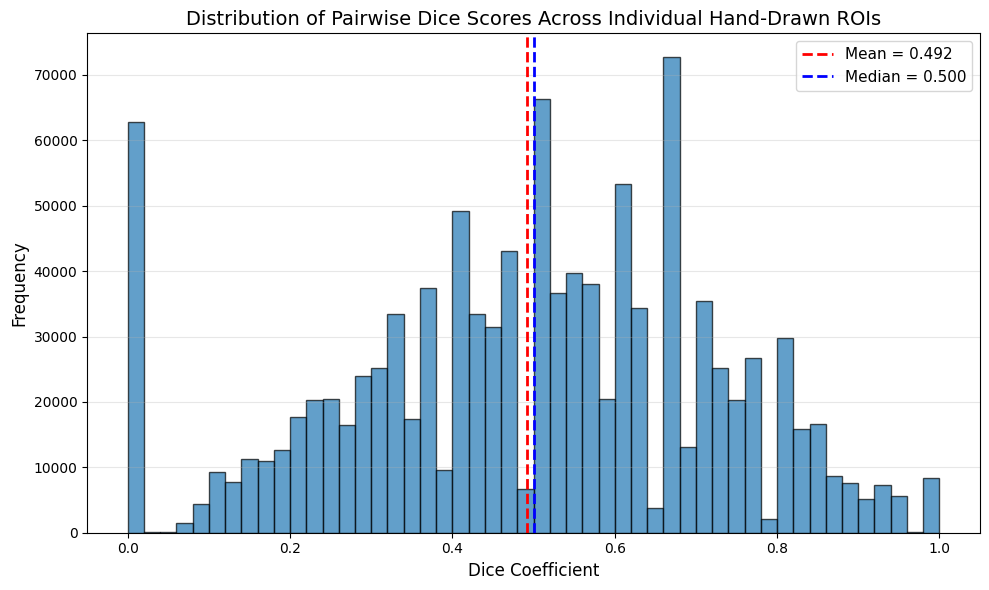

In [42]:
# Create histogram of pairwise Dice scores
results_path = os.path.join(subj_rois_dir, "pairwise_dice_results.pkl.gz")
with gzip.open(results_path, 'rb') as f:
    data = pickle.load(f)

dice_matrix = data['dice_matrix']
roi_names = data['roi_names']
pairwise_values = data['pairwise_dice_values']

plt.figure(figsize=(10, 6))
plt.hist(pairwise_values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Dice Coefficient', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Pairwise Dice Scores Across Individual Hand-Drawn ROIs', fontsize=14)
plt.axvline(np.mean(pairwise_values), color='red', linestyle='--', linewidth=2, 
            label=f'Mean = {np.mean(pairwise_values):.3f}')
plt.axvline(np.median(pairwise_values), color='blue', linestyle='--', linewidth=2,
            label=f'Median = {np.median(pairwise_values):.3f}')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Ensure all NIfTI files are loaded, binarized, and saved in AFNI-compatible format
afni_nii_files = []
for i, roi_file in enumerate(subj_roi_files):
    img = nib.load(roi_file)
    data = img.get_fdata()
    # Binarize: set all nonzero voxels to 1
    bin_data = (data > 0).astype(np.uint8)
    bin_img = nib.Nifti1Image(bin_data, img.affine, img.header)
    temp_fn = os.path.join(subj_rois_dir, f"afni_bin_roi_{i}.nii.gz")
    nib.save(bin_img, temp_fn)
    afni_nii_files.append(temp_fn)

# Use AFNI 3dMean to average all binarized ROIs
avg_subj_roi = os.path.join(subj_rois_dir, "subj_averaged_hbroi.nii.gz")
mean_cmd = f"3dMean -prefix {avg_subj_roi} {' '.join(afni_nii_files)}"
os.system(mean_cmd)

print(f"Averaged binarized ROI saved to: {avg_subj_roi}")
# Clean up temporary binarized ROI files
print("Cleaning up temporary binarized ROI files...")
for temp_file in afni_nii_files:
    if os.path.exists(temp_file):
        os.remove(temp_file)
        print(f"Deleted: {temp_file}")
print("Cleanup completed.")

In [ ]:
# load the atlas based roi
atlas_roi_dir = op.join(rois_dir, "atlas-based-hb")
atlas_roi= glob.glob(op.join(atlas_roi_dir, "*dilated.nii.gz"))

print(atlas_roi)

In [ ]:

atlas_roi_img = nib.load(atlas_roi[0])  # Take first file from the list
avg_roi_img = nib.load(avg_subj_roi)

atlas_roi_resampled = resample_to_img(atlas_roi_img, avg_roi_img, interpolation='nearest')
print(f"Atlas ROI shape: {atlas_roi_resampled.shape}")


In [ ]:
# Calculate Dice coefficient between subject-averaged ROI and atlas ROI
atlas_vs_subj_dice = dice_coefficient(atlas_roi_resampled, avg_roi_img)

print(f"Dice coefficient between Atlas ROI and Subject-Averaged ROI: {atlas_vs_subj_dice:.4f}")